# This script demonstrates how to train a M²VAE with a split MNIST data set and evaluate the Hyperparameter

In [1]:
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
import vae_tools.loader
from vae_tools.mmvae import MmVae, ReconstructionLoss
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
vae_tools.sanity.check()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import glob
import pickle

python version:  3.5.2
keras version: 2.2.4-tf
tensorflow version: 2.0.2
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


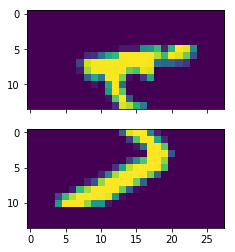

In [2]:

# Get the split MNIST digits
(x_train_a, x_train_b), (x_test_a, x_test_b), y_train, y_test = vae_tools.loader.mnist_split(flatten = True, split = 'hor')

# Show a split image

img_rows, img_cols = 28, 28

f, ax = plt.subplots(2,1,sharex=True)
ax[0].imshow(x_train_a[0,:].reshape(((int(img_rows/2), img_cols))))
ax[1].imshow(x_train_b[0,:].reshape(((int(img_rows/2), img_cols))))
plt.show()


In [3]:
dump_loc = '/mnt/ssd_pcie/mmvae_mnist_split/0/'

df = pd.read_hdf(dump_loc + 'history.h5', key='df', mode='r+')
#df


Opening /mnt/ssd_pcie/mmvae_mnist_split/0/history.h5 in read-only mode


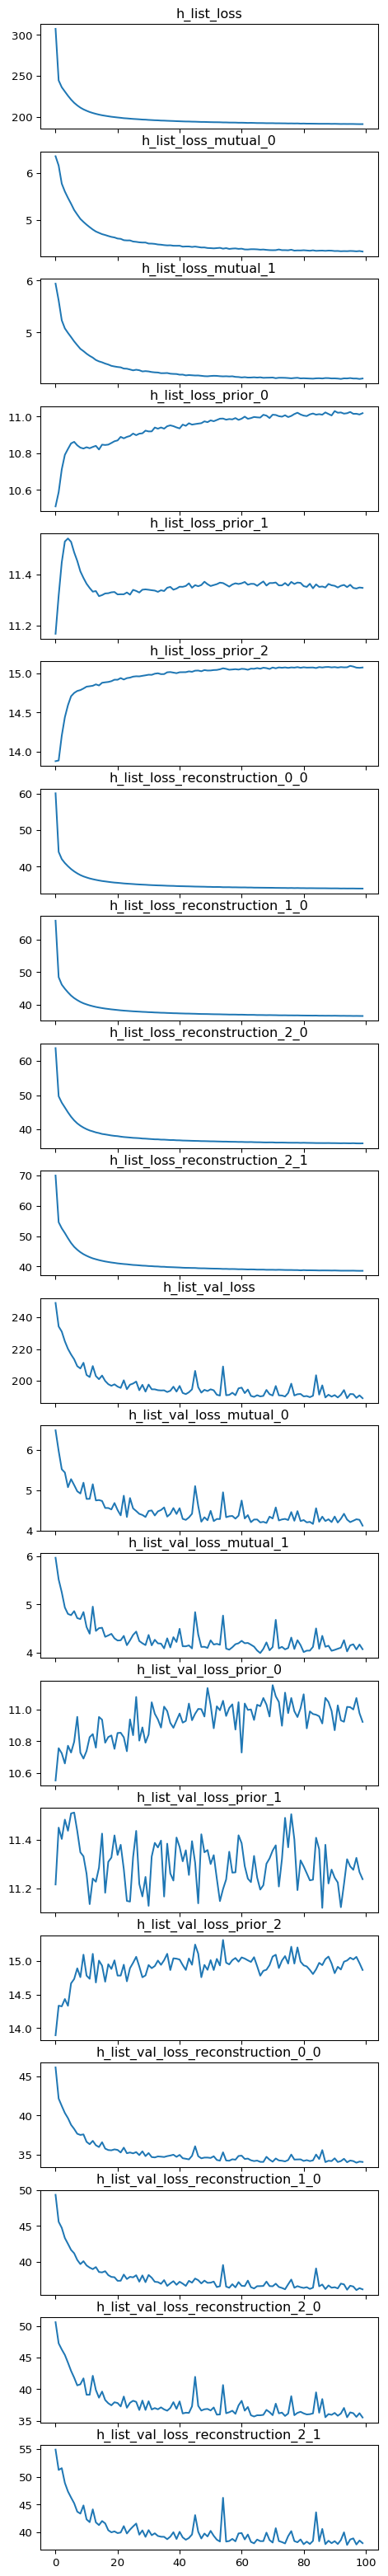

In [4]:
#df.columns
#df['h*'].columns
idx = 1
hist = tf.keras.callbacks.History()
hist.history = df[[c for c in df.columns if c[:6]=='h_list']].to_dict('records')[idx]
vae_tools.viz.plot_losses(hist, dpi=96, figsize_height_factor = .325)
plt.show()
#hist.history

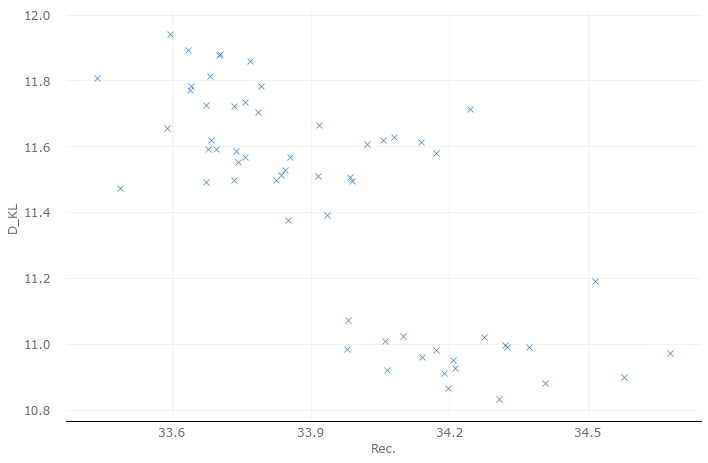

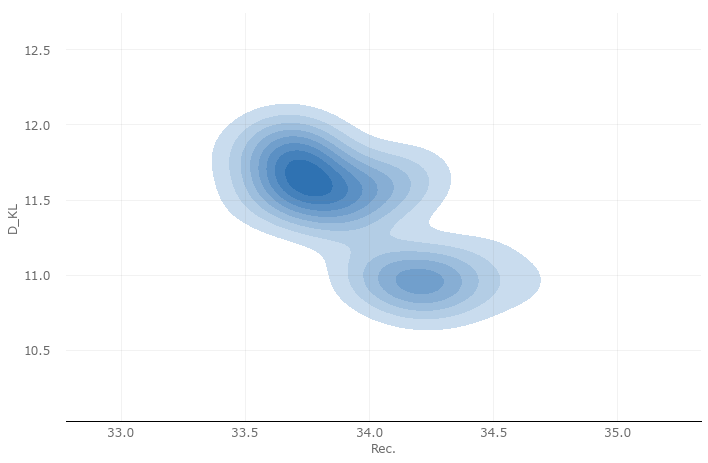

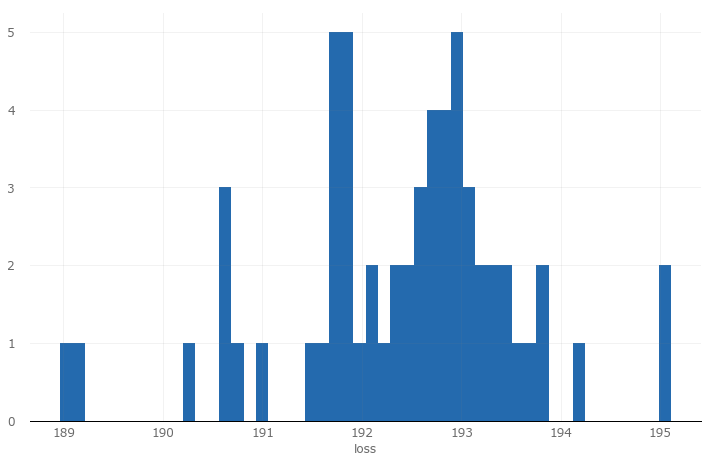

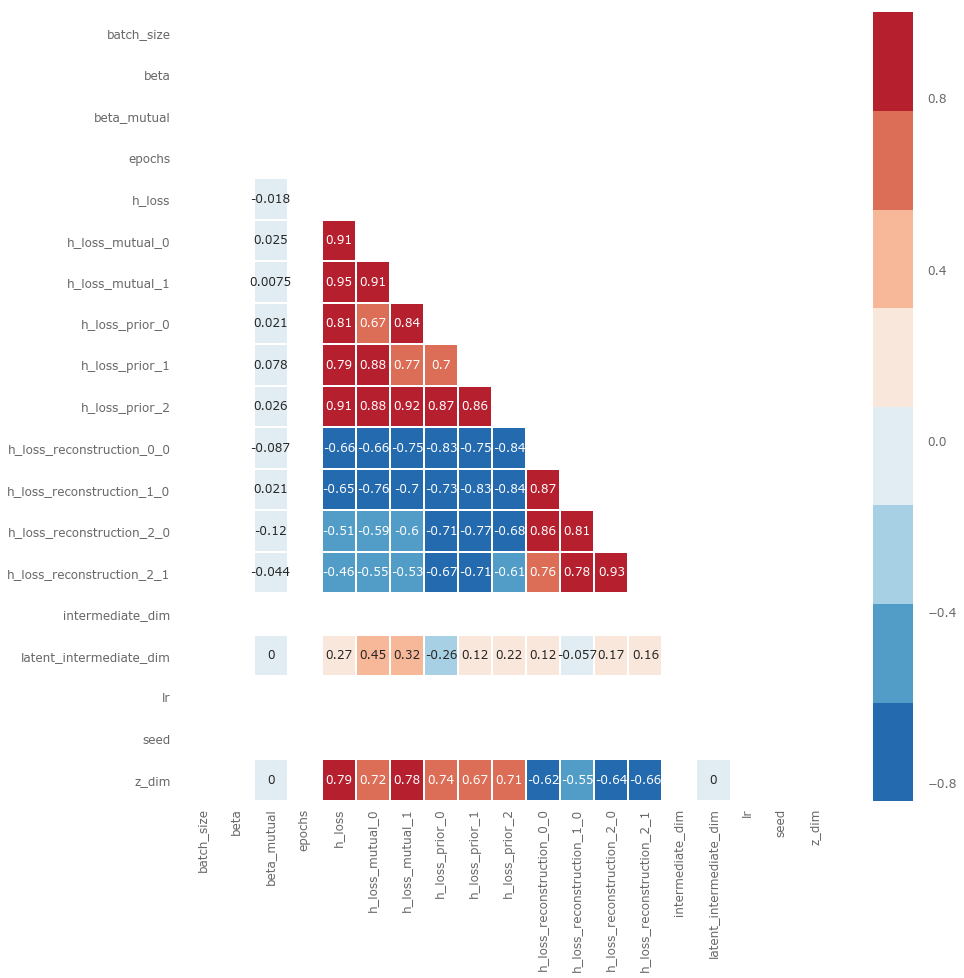

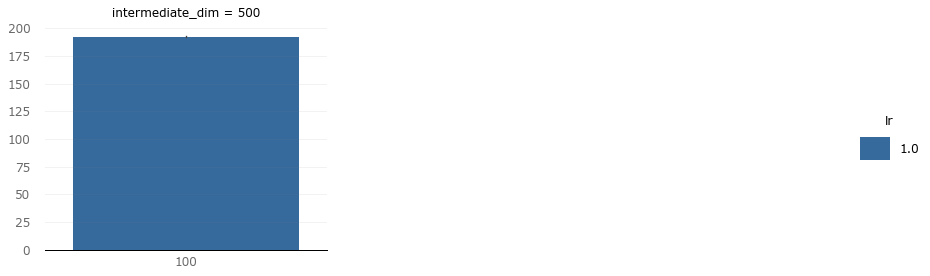

In [5]:
h_prefix = 'h_'
import astetik
%matplotlib inline

# a regression plot for two dimensions
astetik.regs(df, x=h_prefix + 'val_loss_reconstruction_0_0', y=h_prefix + 'val_loss_prior_0', x_label='Rec.', y_label='D_KL')
# up to two dimensional kernel density estimator
astetik.kde(df, x=h_prefix + 'val_loss_reconstruction_0_0', y=h_prefix + 'val_loss_prior_0', x_label='Rec.', y_label='D_KL')
# a simple histogram
astetik.hist(df, h_prefix + 'val_loss',bins=50, x_label='loss')
# correlation w/o validation
_df = df.drop(["activation","reconstruction_loss_metrics","optimizer","index"], axis=1)
_df = _df[[c for c in _df.columns if c[:5] != 'h_val']]
astetik.corr(_df, color_grades=5, style='astetik', annot=True)
# a four dimensional bar grid
astetik.bargrid(df, x='batch_size', y=h_prefix + 'val_loss', hue='lr', col='intermediate_dim',  col_wrap=3)



## Predict the visual data into the latent space using the trained encoder networks

In [6]:
# Get the models and predict all data
def predict(model_path, x_train = None, x_test = None):
    num_models = 2
    model_enc, _ = vae_tools.vae.GenericVae.load_model_powerset(model_path, num_models)
    model_enc_a, model_enc_b, model_enc_ab = model_enc[0], model_enc[1], model_enc[2]
    z_train, z_test = None, None
    if x_train is not None:
        z_train_ab = model_enc_ab.predict(x_train)
        z_train_a = model_enc_a.predict(x_train[0])
        z_train_b = model_enc_b.predict(x_train[1])
        z_train = (z_train_a, z_train_b, z_train_ab)
    if x_test is not None:
        z_test_ab = model_enc_ab.predict(x_test)
        z_test_a = model_enc_a.predict(x_test[0])
        z_test_b = model_enc_b.predict(x_test[1])
        z_test = (z_test_a, z_test_b, z_test_ab)
    # Cleanup
    for m in model_enc:
        del m
    tf.keras.backend.clear_session()
    return z_train, z_test


z_train_mean, z_test_mean = predict(dump_loc + 'enc_mean_' + str(idx) + '_ab_', x_train = [x_train_a, x_train_b], x_test = [x_test_a, x_test_b])
z_train_logvar, z_test_logvar = predict(dump_loc + 'enc_logvar_' + str(idx) + '_ab_', x_train = [x_train_a, x_train_b], x_test = [x_test_a, x_test_b])

z_train_a, z_train_b, z_train_ab = z_train_mean[0], z_train_mean[1], z_train_mean[2]
z_test_a, z_test_b, z_test_ab = z_test_mean[0], z_test_mean[1], z_test_mean[2]

z_train_logvar_a, z_train_logvar_b, z_train_logvar_ab = z_train_logvar[0], z_train_mean[1], z_train_logvar[2]
z_test_logvar_a, z_test_logvar_b, z_test_logvar_ab = z_test_logvar[0], z_test_logvar[1], z_test_logvar[2]


Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_mean_1_ab_10 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_mean_1_ab_01 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_mean_1_ab_11 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_logvar_1_ab_10 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_logvar_1_ab_01 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_logvar_1_ab_11 from disk


## Train a naive Bayesian Classifier on the latent space of the encoder networks

In [7]:
def eval_bayes_classifier(z_train, z_test, y_train, y_test, verbose = False):
    from sklearn.naive_bayes import GaussianNB
    gnb = GaussianNB().fit(z_train, y_train)
    y_pred_ab = gnb.predict(z_test['z_test_ab'])
    y_pred_a = gnb.predict(z_test['z_test_a'])
    y_pred_b = gnb.predict(z_test['z_test_b'])
    if verbose:
        print("Test on %d points." %(y_test.shape[0]))
        print("mislabeled in ab : %d" % ((y_test != y_pred_ab).sum()))
        print("mislabeled in a  : %d" % ((y_test != y_pred_a).sum()))
        print("mislabeled in b  : %d" % ((y_test != y_pred_b).sum()))
    return y_pred_ab, y_pred_a, y_pred_b

z_train_all = {'z_test_ab': z_test_ab, 'z_test_a': z_test_a, 'z_test_b': z_test_b}

print("")
print("Trained on ab")
y_pred_ab_ab, y_pred_ab_a, y_pred_ab_b = eval_bayes_classifier(z_train_ab,
                      z_train_all,
                      y_train,
                      y_test,
                      True)

print("")
print("Trained on a")
y_pred_a_ab, y_pred_a_a, y_pred_a_b = eval_bayes_classifier(z_train_a,
                      z_train_all,
                      y_train,
                      y_test,
                      True)

print("")
print("Trained on b")
y_pred_b_ab, y_pred_b_a, y_pred_b_b = eval_bayes_classifier(z_train_b,
                      z_train_all,
                      y_train,
                      y_test,
                      True)



Trained on ab
Test on 10000 points.
mislabeled in ab : 1112
mislabeled in a  : 1614
mislabeled in b  : 1955

Trained on a
Test on 10000 points.
mislabeled in ab : 1651
mislabeled in a  : 1564
mislabeled in b  : 2508

Trained on b
Test on 10000 points.
mislabeled in ab : 2003
mislabeled in a  : 2566
mislabeled in b  : 1955


## KL and JS Losses

In [8]:
def rel_bar_plot(metric, label, prediction, min, max, bins, ax, wlabel='wrong', clabel='correct'):
    ''' Plot relative bar chart with correct and wrong classifications

    :param metric: 1D array with a metric for each sample
    :param label: 1D array with ground truth label for each sample
    :param prediction: 1D array with predicted label for each sample
    :param min: scalar minimum value of histogram
    :param max: scalar maximum value of histogram
    :param bins: number of bins
    :param ax: axis for plotting
    :param wlabel: string label for correct classified samples
    :param clabel: string label for wrong classified samples
    '''
    mw = metric[(label != prediction)]
    mc = metric[(label == prediction)]
    h_cw, edges = np.histogram(metric, bins, range=(min, max))
    h_c, edges = np.histogram(mc, bins, range=(min, max))
    h_w, edges = np.histogram(mw, bins, range=(min, max))

    # Format the values
    skip = edges[1]-edges[0]
    barWidth = skip*0.9
    x = [r+skip/2. for r in edges[:-1]]
    h_c = h_c / h_cw
    h_w = h_w / h_cw

    #raw_data = {'correct': h_c, 'wrong': h_w}
    #df = pd.DataFrame(raw_data)
    ax.bar(x, h_w, color='#f9bc86', edgecolor='white', width=barWidth, label=wlabel)
    ax.bar(x, h_c, bottom=h_w, color='#b5ffb9', edgecolor='white', width=barWidth, label=clabel)
    ax.set_xlim((min, max))

### KL

In [9]:
kl_ab_ab = vae_tools.metrics.kl_sym_loss(z_test_ab, z_test_ab, z_test_logvar_ab, z_test_logvar_a)
kl_ab_a = vae_tools.metrics.kl_sym_loss(z_test_ab, z_test_a, z_test_logvar_ab, z_test_logvar_a)
kl_ab_b = vae_tools.metrics.kl_sym_loss(z_test_ab, z_test_b, z_test_logvar_ab, z_test_logvar_b)
kl_a_b = vae_tools.metrics.kl_sym_loss(z_test_a, z_test_b, z_test_logvar_a, z_test_logvar_b)

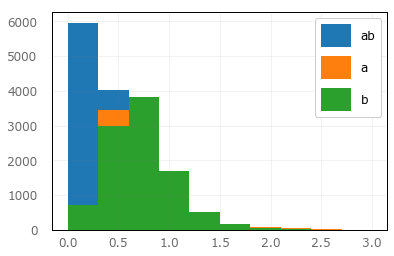

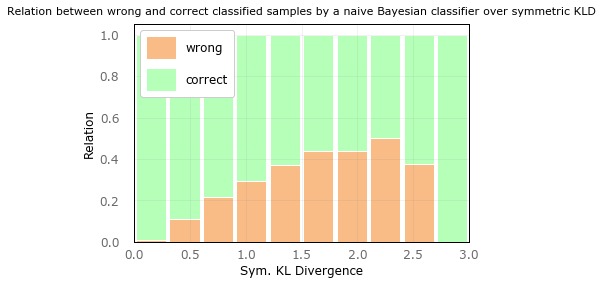

In [10]:
min = 0.
max = 3.
bins = 10
yx = plt.hist(kl_ab_ab.mean(axis=-1), bins, range=(min, max), label='ab')
yx_c = plt.hist(kl_ab_a.mean(axis=-1), bins, range=(min, max), label='a')
yx_w = plt.hist(kl_ab_b.mean(axis=-1), bins, range=(min, max), label='b')
plt.legend(loc='upper right')
plt.show()


_, ax = plt.subplots(1,1)
rel_bar_plot(kl_ab_b.mean(axis=-1), y_test, y_pred_ab_b, .0, 3., 10, ax)
ax.legend(loc='upper left')
ax.set_xlabel('Sym. KL Divergence')
ax.set_ylabel('Relation')
ax.set_title('Relation between wrong and correct classified samples by a naive Bayesian classifier over symmetric KLD')
plt.show()


### JS

In [11]:
loc = dump_loc + 'jsd_' + str(idx) + '_ab.p'
js = pickle.load( open( loc, "rb" ) )

#print(js)

# js structure:
# js = {'test_ab_vs_ab': js_d_ab,
#               'test_ab_vs_a': js_d_ab_a,
#               'test_ab_vs_b': js_d_ab_b,
#               'test_b_vs_a': js_d_b_a,
#               'train_ab_vs_ab': js_d_ab_train,
#               'train_ab_vs_a': js_d_ab_a_train,
#               'train_ab_vs_b': js_d_ab_b_train,
#               'train_b_vs_a': js_d_b_a_train}

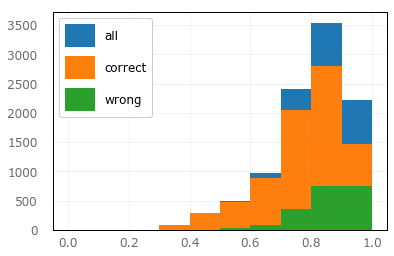

In [12]:
mw = js['test_ab_vs_b'][(y_test != y_pred_ab_b)]
mc = js['test_ab_vs_b'][(y_test == y_pred_ab_b)]
yx = plt.hist(js['test_ab_vs_b'], range=(.0, 1.), label='all')
yx_c = plt.hist(mc, range=(.0, 1.), label='correct')
yx_w = plt.hist(mw, range=(.0, 1.), label='wrong')
plt.legend(loc='upper left')
plt.show()

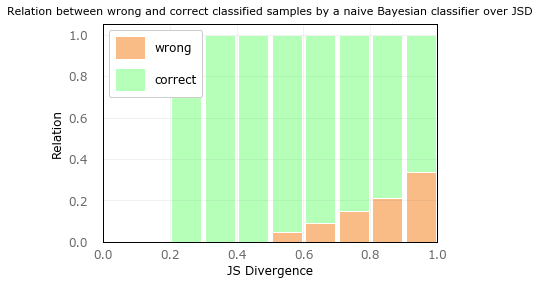

In [13]:
f, ax = plt.subplots()
rel_bar_plot(js['test_ab_vs_b'], y_test, y_pred_ab_b, 0.0, 1., 10, ax)
plt.legend(loc='upper left')
ax.set_xlim((0., 1.))
ax.set_xlabel('JS Divergence')
ax.set_ylabel('Relation')
plt.title('Relation between wrong and correct classified samples by a naive Bayesian classifier over JSD')
plt.show()

## Load the JSD and average it over all samples

In [14]:
prefix = 'jsd_'
jsd = None
for idx in df['index']:
    loc = dump_loc + 'jsd_' + str(idx) + '_ab.p'
    data = pickle.load( open( loc, "rb" ) )
    if jsd is None:
        jsd = {}
        for k in data.keys():
            jsd[prefix + k] = []
    for k in data.keys():
        #print(np.mean(js[k]))
        jsd[prefix + k].append(np.mean(data[k]))
# Add the JSD to the pandas data frame
df_jsd = pd.DataFrame(jsd, columns=jsd.keys())

## Load the GNB classifications and calculate the precision

In [15]:
#_df = df

gnb = None
prefix = 'gnb_prec_'
denom = len(y_test)
for idx in df['index']:
    loc = dump_loc + 'bayes_classifier_' + str(idx) + '.p'
    data = pickle.load( open( loc, "rb" ) )
    if gnb is None:
        gnb = {}
        for k in data.keys():
            gnb[prefix + k] = []
    for k in data.keys():
        #print(np.mean(js[k]))
        gnb[prefix + k].append(np.sum((data[k] == y_test))/denom)
# Add the JSD to the pandas data frame
df_gnb = pd.DataFrame(gnb, columns=gnb.keys())



## Show the correlation matrix

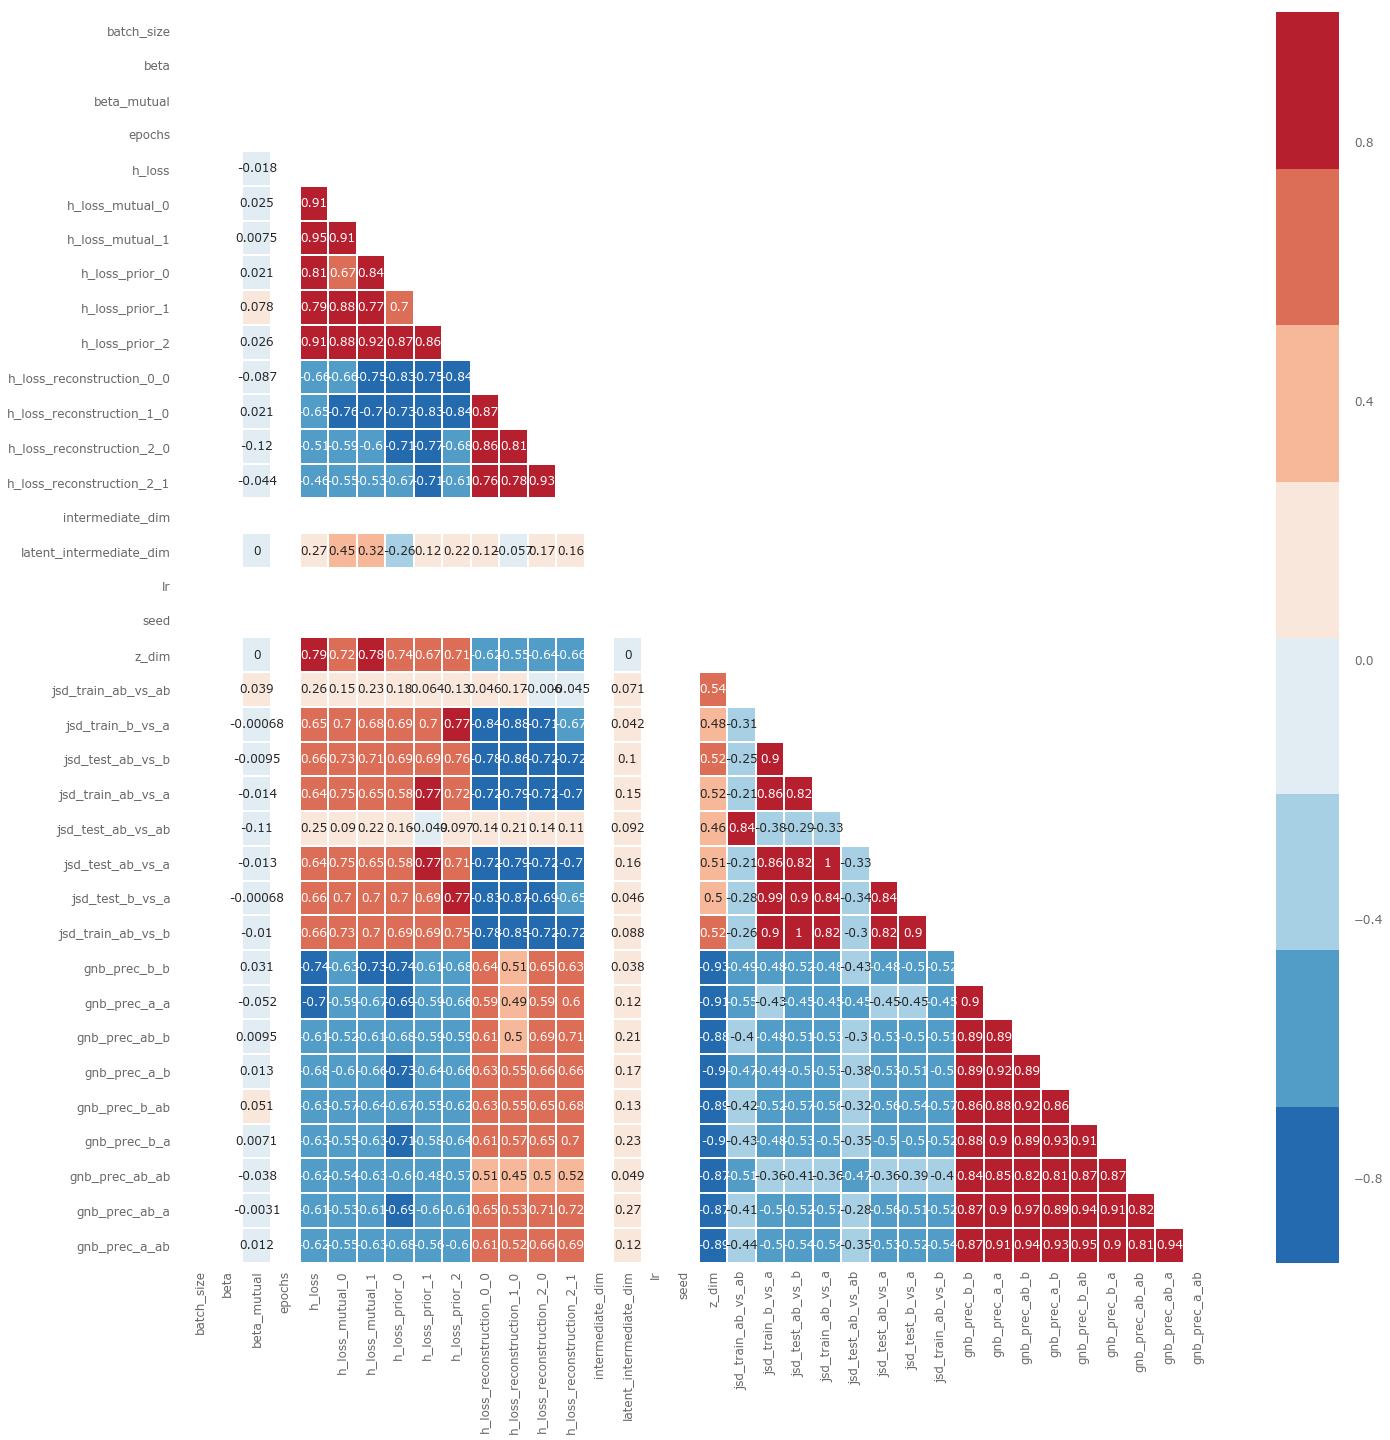

In [19]:
_df = pd.concat([df, df_jsd, df_gnb], axis =1) # .reset_index()

# correlation w/o validation
_df = _df.drop(["activation","reconstruction_loss_metrics","optimizer","index"], axis=1)
_df = _df[[c for c in _df.columns if c[:5] != 'h_val']]


astetik.corr(_df, color_grades=5, style='astetik', annot=True)
#_df

In [17]:

df

,activation,batch_size,beta,beta_mutual,epochs,h_list_loss,h_list_loss_mutual_0,h_list_loss_mutual_1,h_list_loss_prior_0,h_list_loss_prior_1,...,h_val_loss_reconstruction_2_1,index,intermediate_dim,latent_activation,latent_intermediate_dim,lr,optimizer,reconstruction_loss_metrics,seed,z_dim
0,tanh,100,1.0,0.001,100,"[307.4697631835937, 245.11216575622558, 236.61...","[6.457102, 6.265106, 5.926454, 5.751457, 5.620...","[5.8932786, 5.6134005, 5.1840053, 5.00573, 4.8...","[10.509021, 10.630142, 10.71141, 10.770787, 10...","[11.239642, 11.3773775, 11.5531225, 11.62331, ...",...,37.681324,0,500,tanh,NaN,1.0,<class 'tensorflow.python.keras.optimizer_v2.r...,BCE,0,20
1,tanh,100,1.0,0.010,100,"[307.4477105204264, 244.32769475301106, 236.02...","[6.358194, 6.1595984, 5.7761264, 5.6090274, 5....","[5.939133, 5.6162066, 5.2348623, 5.0796523, 4....","[10.509859, 10.587084, 10.711484, 10.790524, 1...","[11.167818, 11.316763, 11.447037, 11.528435, 1...",...,38.012299,1,500,tanh,NaN,1.0,<class 'tensorflow.python.keras.optimizer_v2.r...,BCE,0,20
2,tanh,100,1.0,0.100,100,"[307.46572812398273, 245.08602513631186, 236.6...","[6.4544773, 6.2648764, 5.9138293, 5.747117, 5....","[5.8978286, 5.6152506, 5.180624, 5.000226, 4.8...","[10.515862, 10.630003, 10.715018, 10.769475, 1...","[11.238543, 11.376992, 11.549229, 11.623627, 1...",...,38.844624,2,500,tanh,NaN,1.0,<class 'tensorflow.python.keras.optimizer_v2.r...,BCE,0,20
3,tanh,100,1.0,1.000,100,"[307.1951137797038, 245.29828943888347, 236.94...","[6.4259152, 6.244776, 5.8489766, 5.6501455, 5....","[5.9927278, 5.6870995, 5.2599173, 5.0821037, 4...","[10.560446, 10.704062, 10.8052025, 10.8689785,...","[11.215757, 11.362302, 11.467892, 11.540279, 1...",...,39.927170,3,500,tanh,NaN,1.0,<class 'tensorflow.python.keras.optimizer_v2.r...,BCE,0,20
4,tanh,100,1.0,10.000,100,"[307.2410603841146, 244.68325403849283, 236.30...","[6.4250035, 6.2048116, 5.798397, 5.6242375, 5....","[5.970219, 5.6004586, 5.2197394, 5.076556, 4.9...","[10.573162, 10.61395, 10.737091, 10.821522, 10...","[11.219943, 11.378166, 11.52766, 11.604924, 11...",...,38.575157,4,500,tanh,NaN,1.0,<class 'tensorflow.python.keras.optimizer_v2.r...,BCE,0,20
5,tanh,100,1.0,0.001,100,"[311.7779707845052, 247.41772641499838, 238.80...","[6.2042975, 6.443716, 6.1716323, 5.9827757, 5....","[5.923681, 5.8413014, 5.410199, 5.262828, 5.15...","[10.446096, 10.550474, 10.703788, 10.780138, 1...","[10.886382, 11.183301, 11.405573, 11.514904, 1...",...,38.381073,5,500,tanh,125.0,1.0,<class 'tensorflow.python.keras.optimizer_v2.r...,BCE,0,20
6,tanh,100,1.0,0.010,100,"[311.8791663614909, 248.3565734354655, 239.351...","[6.341951, 6.4594235, 6.0486503, 5.8141937, 5....","[5.9525337, 5.9893336, 5.577739, 5.3932867, 5....","[10.480907, 10.723864, 10.824521, 10.825718, 1...","[11.043667, 11.252028, 11.392997, 11.47612, 11...",...,38.723373,6,500,tanh,125.0,1.0,<class 'tensorflow.python.keras.optimizer_v2.r...,BCE,0,20
7,tanh,100,1.0,0.100,100,"[312.2645930480957, 247.83954493204752, 239.26...","[6.2754445, 6.462002, 6.1124926, 5.8972545, 5....","[5.876986, 5.9081826, 5.497428, 5.3313656, 5.2...","[10.503249, 10.653686, 10.761726, 10.832609, 1...","[10.984032, 11.259344, 11.408778, 11.4890785, ...",...,38.947060,7,500,tanh,125.0,1.0,<class 'tensorflow.python.keras.optimizer_v2.r...,BCE,0,20
8,tanh,100,1.0,1.000,100,"[312.0420034281413, 248.80144236246744, 240.10...","[6.299462, 6.510923, 6.223576, 6.015276, 5.840...","[5.906736, 6.0259004, 5.529561, 5.3126874, 5.2...","[10.473075, 10.667283, 10.788038, 10.851717, 1...","[10.964331, 11.248226, 11.508341, 11.600928, 1...",...,38.843655,8,500,tanh,125.0,1.0,<class 'tensorflow.python.keras.optimizer_v2.r...,BCE,0,20
9,tanh,100,1.0,10.000,100,"[311.674294052124, 247.30736526489258, 238.771...","[6.2016783, 6.452559, 6.1700687, 5.971256, 5.7...","[5.9220953, 5.8310723, 5.418454, 5.266309, 5.1...","[10.438836, 10.548032, 10.700102, 10.778778, 1...","[10.886038, 11.181401, 11.400844, 11.511333, 1...",...,38.353191,9,500,

In [18]:
_df

,level_0,batch_size,beta,beta_mutual,epochs,h_list_loss,h_list_loss_mutual_0,h_list_loss_mutual_1,h_list_loss_prior_0,h_list_loss_prior_1,...,jsd_train_ab_vs_b,gnb_prec_b_b,gnb_prec_a_a,gnb_prec_ab_b,gnb_prec_a_b,gnb_prec_b_ab,gnb_prec_b_a,gnb_prec_ab_ab,gnb_prec_ab_a,gnb_prec_a_ab
0,0,100,1.0,0.001,100,"[307.4697631835937, 245.11216575622558, 236.61...","[6.457102, 6.265106, 5.926454, 5.751457, 5.620...","[5.8932786, 5.6134005, 5.1840053, 5.00573, 4.8...","[10.509021, 10.630142, 10.71141, 10.770787, 10...","[11.239642, 11.3773775, 11.5531225, 11.62331, ...",...,0.796023,0.8152,0.8361,0.8138,0.7071,0.7557,0.7007,0.8850,0.8298,0.7903
1,1,100,1.0,0.010,100,"[307.4477105204264, 244.32769475301106, 236.02...","[6.358194, 6.1595984, 5.7761264, 5.6090274, 5....","[5.939133, 5.6162066, 5.2348623, 5.0796523, 4....","[10.509859, 10.587084, 10.711484, 10.790524, 1...","[11.167818, 11.316763, 11.447037, 11.528435, 1...",...,0.792868,0.8045,0.8436,0.8045,0.7492,0.7997,0.7434,0.8888,0.8386,0.8349
2,2,100,1.0,0.100,100,"[307.46572812398273, 245.08602513631186, 236.6...","[6.4544773, 6.2648764, 5.9138293, 5.747117, 5....","[5.8978286, 5.6152506, 5.180624, 5.000226, 4.8...","[10.515862, 10.630003, 10.715018, 10.769475, 1...","[11.238543, 11.376992, 11.549229, 11.623627, 1...",...,0.798596,0.8159,0.8390,0.8106,0.7139,0.7704,0.7167,0.8846,0.8283,0.7866
3,3,100,1.0,1.000,100,"[307.1951137797038, 245.29828943888347, 236.94...","[6.4259152, 6.244776, 5.8489766, 5.6501455, 5....","[5.9927278, 5.6870995, 5.2599173, 5.0821037, 4...","[10.560446, 10.704062, 10.8052025, 10.8689785,...","[11.215757, 11.362302, 11.467892, 11.540279, 1...",...,0.801981,0.8063,0.8342,0.8010,0.6969,0.7588,0.7090,0.8796,0.8263,0.7697
4,4,100,1.0,10.000,100,"[307.2410603841146, 244.68325403849283, 236.30...","[6.4250035, 6.2048116, 5.798397, 5.6242375, 5....","[5.970219, 5.6004586, 5.2197394, 5.076556, 4.9...","[10.573162, 10.61395, 10.737091, 10.821522, 10...","[11.219943, 11.378166, 11.52766, 11.604924, 11...",...,0.783419,0.8046,0.8310,0.8000,0.7425,0.7950,0.7343,0.8778,0.8259,0.8223
5,5,100,1.0,0.001,100,"[311.7779707845052, 247.41772641499838, 238.80...","[6.2042975, 6.443716, 6.1716323, 5.9827757, 5....","[5.923681, 5.8413014, 5.410199, 5.262828, 5.15...","[10.446096, 10.550474, 10.703788, 10.780138, 1...","[10.886382, 11.183301, 11.405573, 11.514904, 1...",...,0.789316,0.8110,0.8442,0.8088,0.7563,0.8094,0.7596,0.8877,0.8310,0.8381
6,6,100,1.0,0.010,100,"[311.8791663614909, 248.3565734354655, 239.351...","[6.341951, 6.4594235, 6.0486503, 5.8141937, 5....","[5.9525337, 5.9893336, 5.577739, 5.3932867, 5....","[10.480907, 10.723864, 10.824521, 10.825718, 1...","[11.043667, 11.252028, 11.392997, 11.47612, 11...",...,0.800411,0.8090,0.8370,0.7986,0.7128,0.7851,0.7405,0.8760,0.8240,0.7936
7,7,100,1.0,0.100,100,"[312.2645930480957, 247.83954493204752, 239.26...","[6.2754445, 6.462002, 6.1124926, 5.8972545, 5....","[5.876986, 5.9081826, 5.497428, 5.3313656, 5.2...","[10.503249, 10.653686, 10.761726, 10.832609, 1...","[10.984032, 11.259344, 11.408778, 11.4890785, ...",...,0.798202,0.8090,0.8402,0.8001,0.7388,0.8263,0.7665,0.8887,0.8346,0.8295
8,8,100,1.0,1.000,100,"[312.0420034281413, 248.80144236246744, 240.10...","[6.299462, 6.510923, 6.223576, 6.015276, 5.840...","[5.906736, 6.0259004, 5.529561, 5.3126874, 5.2...","[10.473075, 10.667283, 10.788038, 10.851717, 1...","[10.964331, 11.248226, 11.508341, 11.600928, 1...",...,0.800100,0.8149,0.8455,0.8144,0.7444,0.7863,0.7489,0.8839,0.8370,0.8175
9,9,100,1.0,10.000,100,"[311.674294052124, 247.30736526489258, 238.771...","[6.2016783, 6.452559, 6.1700687, 5.971256, 5.7...","[5.9220953, 5.8310723, 5.418454, 5.266309, 5.1...","[10.438836, 10.548032, 10.700102, 10.778778, 1...","[10.886038, 11.181401, 11.400844, 11.511333, 1...",...,0.790522,0.8135,0.8452,0.8112,0.7638,0.7998,0.7564,0.8862,0.8296,0.8361
